# 

# Predict stock forecast

An attempt to predict stock forecast with data from https://finance.yahoo.com.

My idea is to use historical data to train the model through supervised learning to find out if to buy (1) or not buy (0) stock a certain date.

In [79]:
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

Defining constants

In [80]:
YEARS = 4
SYMBOL = "MSFT"

start = datetime.date.today() - datetime.timedelta(days=YEARS * 365)
end = datetime.datetime.today()

Library yfinance parses data from Yahoo finance, in this case MSFT data 4 years prior.

In [81]:
df = yf.download(SYMBOL, start, end)
df.to_csv(r'data\msft_data.csv')

[*********************100%***********************]  1 of 1 completed


In [82]:
df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [83]:
df.shape

(1006, 6)

In [84]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

C:\Users\Marcus\AppData\Local\Temp\ipykernel_5036\3701478658.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i+1)


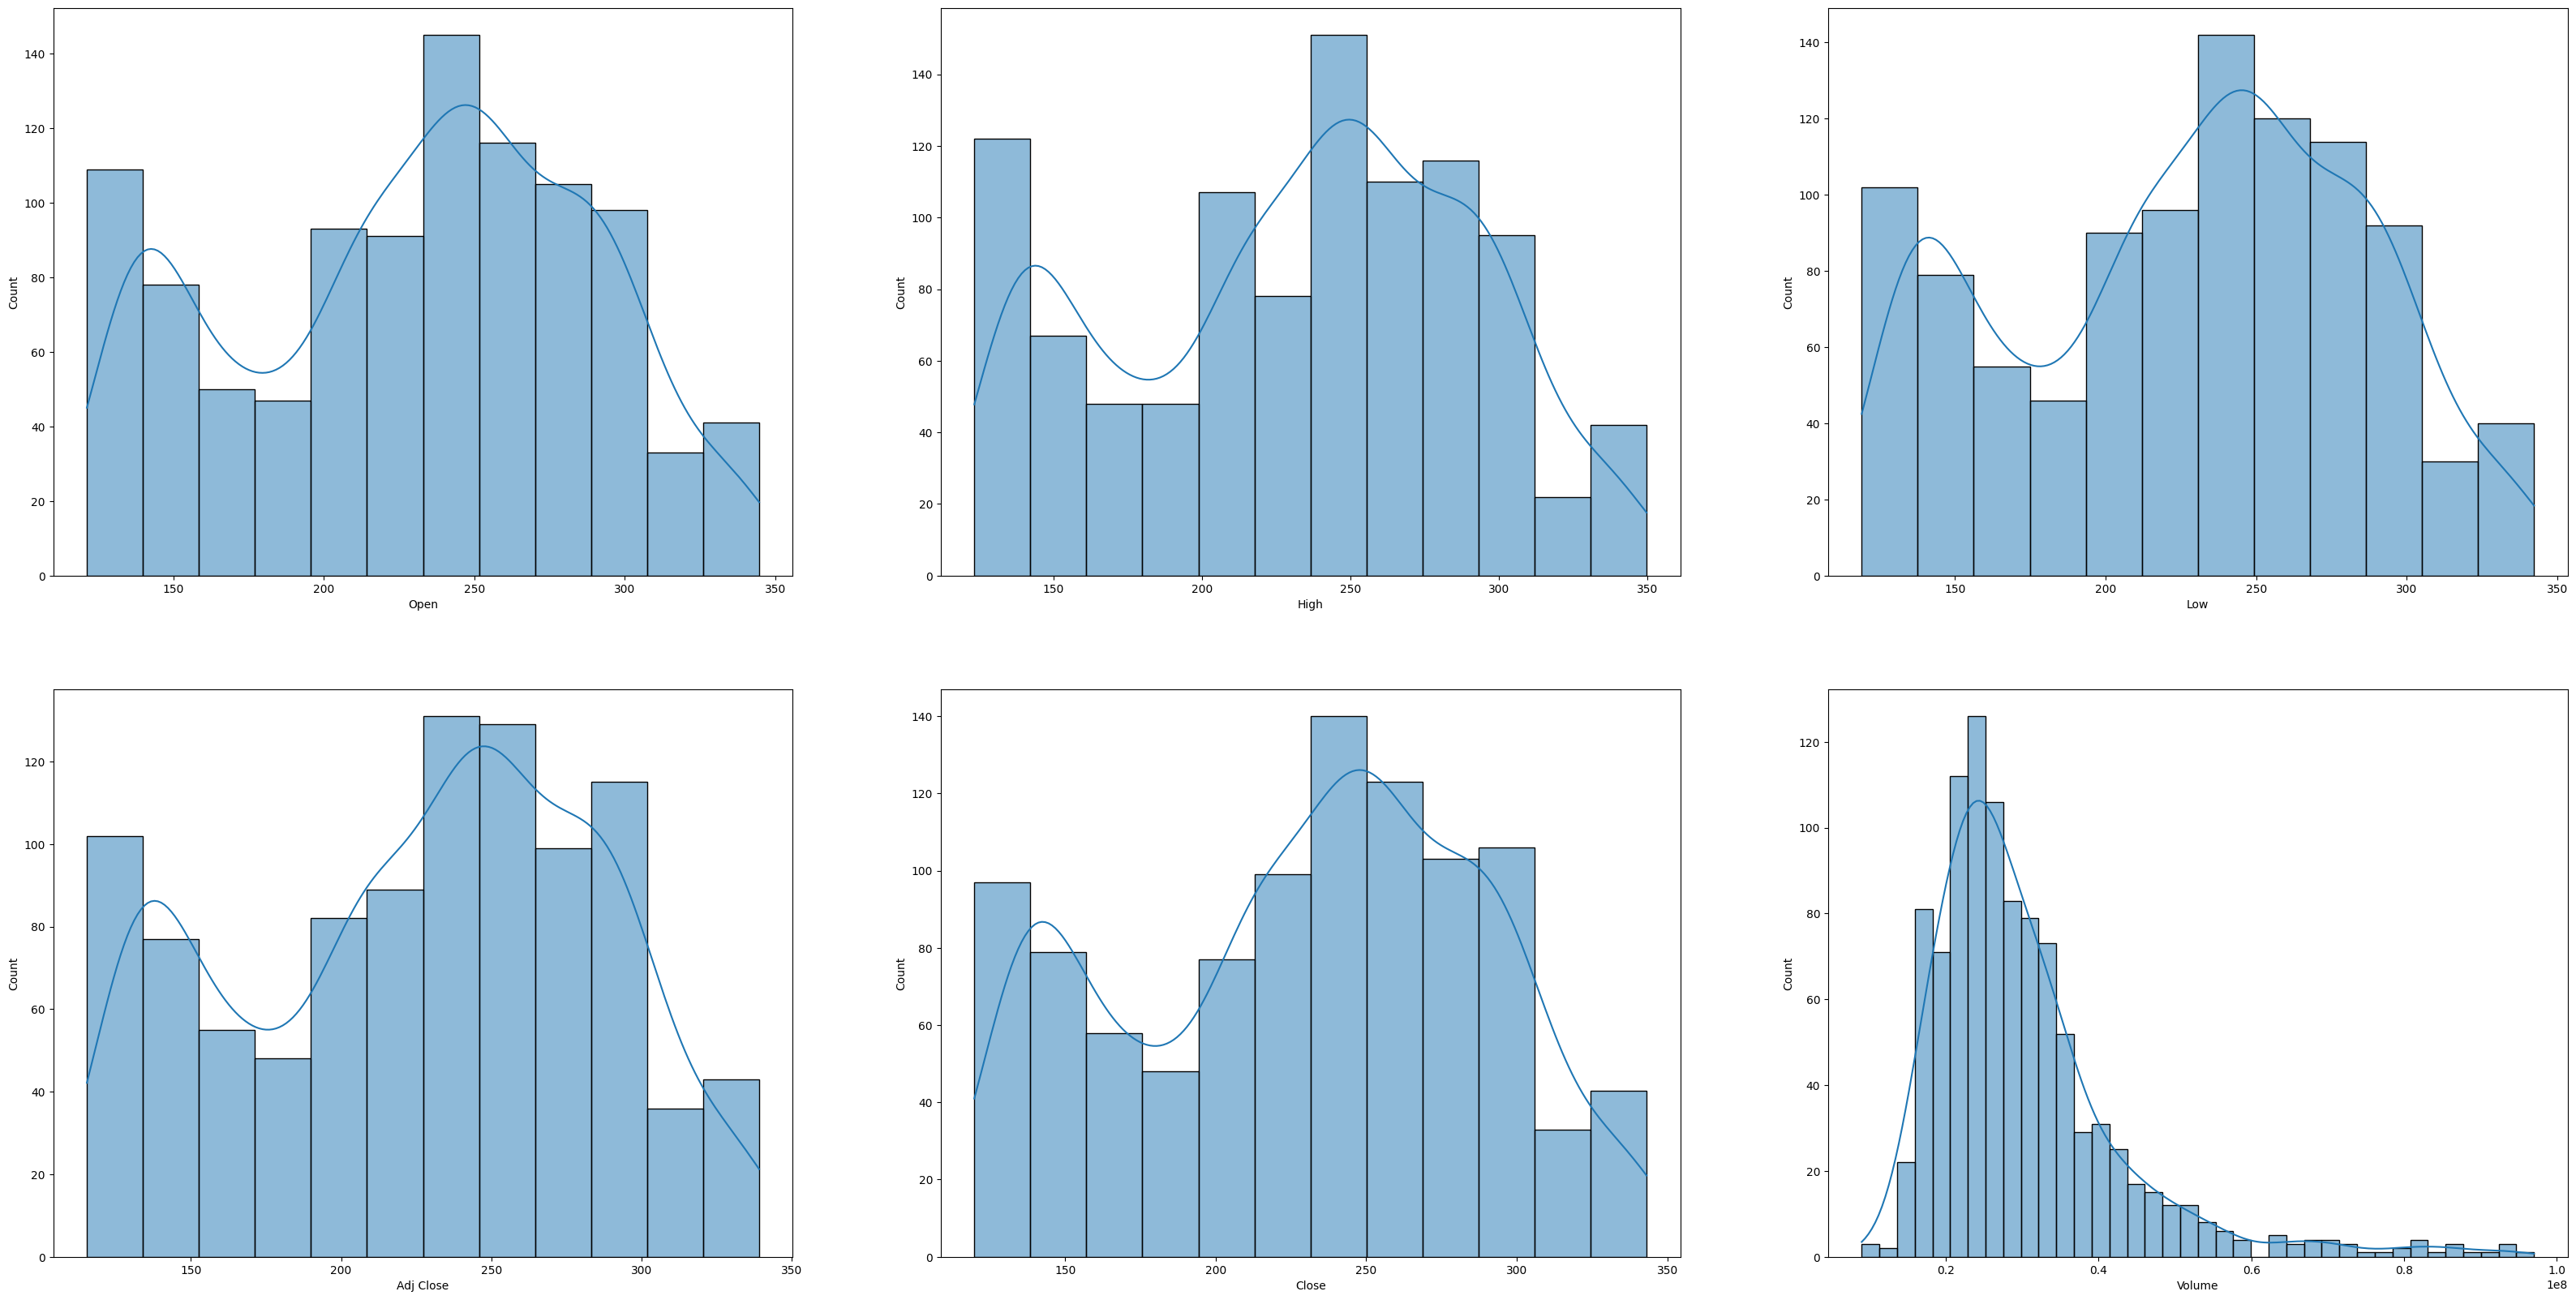

In [93]:
features = ['Open', 'High', 'Low', 'Adj Close', 'Close', 'Volume']

plt.subplots(figsize=(40, 20))
for i, column in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[column], kde=True)
plt.show()

Close and Adj Close columns above are similare but not equal, may go with adjusted close price as it a more comprehensive measure

In [70]:
df[df['Close'] == df['Adj Close']].shape

(53, 6)

Plot on closing x days prior.

<Axes: xlabel='Date'>

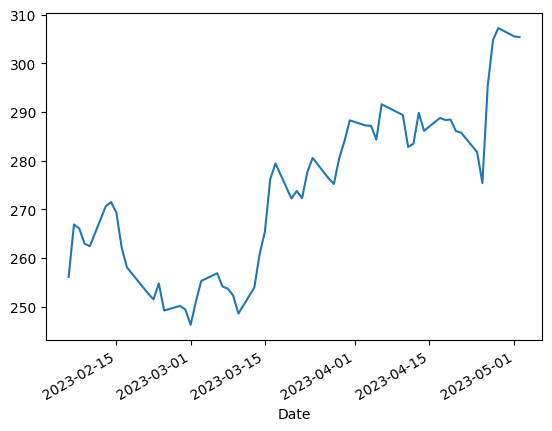

In [71]:
tmp = df['Adj Close'].iloc[-60:]  # 60 days
tmp.plot()

Smooths dataset 

<Axes: xlabel='Date'>

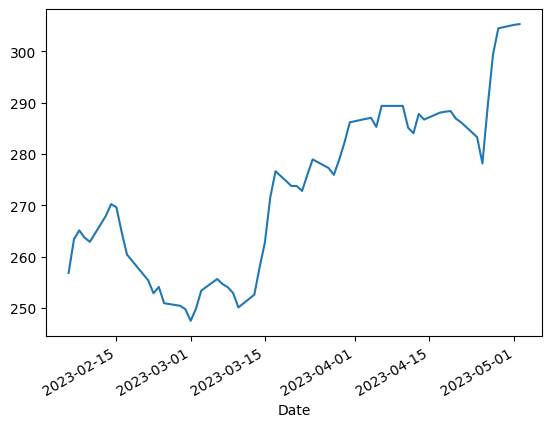

In [72]:
# alpha as weight factor, weight recent values more
df = df.ewm(alpha=0.65).mean()
temp = df['Adj Close'].iloc[-60:]  # 60 days
temp.plot()

The historical data is not very rich of features. Open, High, Low, Close are not very interesting as Adj Close can fulfil the need. FinTA library can do financial analysis with list of symbols as indicators:

In [73]:
from finta import TA

# From finTA use the following indicators:

"""
RSI - Relative Strength Index
MACD = Moving Average Convergence Divergence
STOCH = Stochastic Oscillator
ADL = Accumulation/Distribution Line
ATR = Average True Range
MOM = Momentum
MFI = Money Flow Index
ROC = Rate of Change
OBV = On Balance Volume
CCI = Commodity Channel Index
EMV = Ease of Movement
VORTEX = Vortex Indicator
"""

INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']


In [74]:
# Lower columns needed for finta processing
df.columns = df.columns.str.lower()

for indicator in INDICATORS:
    indicator_data = eval(f'TA.{indicator}(df)')

    # Add indicator to dataframe
    df = df.merge(indicator_data, left_index=True, right_index=True)
df.columns = df.columns.str.replace('.', '')

# Exponential Moving Average (EMA) - 50, 20, 15, 5 used in this case
df['ema50'] = df['adj close'].ewm(50).mean()
df['ema20'] = df['adj close'].ewm(20).mean()
df['ema15'] = df['adj close'].ewm(15).mean()
df['ema5'] = df['adj close'].ewm(5).mean()

# Can use normalized volume instead of actual
df['norm_volume'] = df['volume'] / df['volume'].ewm(5).mean()
# Drop unnecessary columns
df.drop(columns=['open', 'high', 'low', 'volume', 'close'], axis=1, inplace=True)

df.columns


Index(['adj close', '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K',
       'MFV', '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV',
       '20 period CCI', '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema20',
       'ema15', 'ema5', 'norm_volume'],
      dtype='object')

In [76]:
df.to_csv(r'data\msft_data_emw.csv')

In [77]:
df.tail(10)

,adj close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema20,ema15,ema5,norm_volume
Date,,,,,,,,,,,,,,,,,,,,
2023-04-19,288.385814,66.850991,6.029424,6.661879,74.471954,1.785361e+09,5.380453,1.316542,66.145273,0.769632,2.208405e+09,71.040153,0.120854,0.831200,1.076166,262.207445,274.048060,277.750290,286.238298,0.774927
2023-04-20,286.906525,63.328292,5.665076,6.462518,53.189778,1.782172e+09,5.395844,1.611283,59.575590,0.014947,2.186788e+09,56.637900,0.089377,0.888361,1.044153,262.691741,274.660368,278.322555,286.349669,0.915996
2023-04-21,286.161290,61.568146,5.255609,6.221137,43.749845,1.789514e+09,5.280425,-3.232049,52.159777,-0.316293,2.165140e+09,26.812938,0.031476,0.968725,0.998594,263.151928,275.208031,278.812476,286.318273,0.930140
2023-04-24,283.306944,55.235734,4.647212,5.906352,25.954265,1.791101e+09,5.355562,-6.084234,44.510115,-0.696927,2.140265e+09,-38.553837,-0.018627,0.995498,0.931684,263.547125,275.593694,279.093380,285.816385,1.056626
2023-04-25,278.180439,46.070642,3.708636,5.466809,7.180820,1.765910e+09,5.457074,-6.945964,35.472858,-3.874623,2.101808e+09,-136.993234,-0.073021,1.050231,0.865384,263.834052,275.716872,279.036321,284.543727,1.477602
2023-04-26,289.353651,61.186701,3.822331,5.137913,73.305412,1.745753e+09,6.257793,5.290916,47.247807,-0.012968,2.157257e+09,139.918248,0.033040,0.896016,0.908274,264.334437,276.366243,279.681154,285.345381,1.792693
2023-04-27,299.413269,69.480881,4.670326,5.044396,92.537592,1.775007e+09,6.527831,11.595314,50.379819,5.010713,2.206865e+09,323.507622,0.095064,0.814311,0.945787,265.022257,277.463720,280.914412,287.690029,1.457183
2023-04-28,304.513650,72.669788,5.688354,5.173187,94.104517,1.795107e+09,6.585666,17.786357,52.584815,7.199436,2.247919e+09,350.161406,0.159416,0.753039,1.006605,265.796598,278.751812,282.389364,290.493966,1.165885
2023-05-01,305.193776,73.073820,6.475385,5.433627,91.584553,1.791673e+09,6.418103,17.119231,59.188947,6.037087,2.276128e+09,265.136125,0.217033,0.723025,1.086791,266.569092,280.010953,283.814640,292.943934,0.828603


In [105]:
# TODO 1. Extract sample data for later predictions with training set and test set.
# TODO 2. Create 0 and 1 values by comparing one day from another with df.shift().
# TODO 3. Drop NaN values.
# TODO 4. Model creation. Will try KNN, Random forest model, SVM.
